# DoE (Design of Experiment)
Disediakan dataset <i>Banknote Authentication</i> yang dapat didownload pada link [berikut](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#). Lakukan prediksi apakah suatu data banknote authentic atau forgery (kolom **class**), bernilai 0 jika authentic, dan 1 jika forgery.

Author : Michael Jonathan Halim 13521124

# 0. Loading Data and Library

In [467]:
# Put your library here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [468]:
# Read data here
df = pd.read_csv("data_banknote_authentication.csv")

# I. Data Understanding
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal ini meliputi:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (outlier)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instances dan features)
2. Tipe dari tiap-tiap fitur 
3. Banyaknya unique values dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur yang tidak bertipe kategorikal

In [469]:
# I.1 Put your code here
# 1. Get shape
instances = df.shape[0]
features = df.shape[1]

# Print shape
print(f"Jumlah instances: {instances}")
print(f"Jumlah features: {features}")

Jumlah instances: 1372
Jumlah features: 5


In [470]:
# 2. Tipe dari fitur-fitur
print("Tipe dari tiap-tiap fitur:")
df.dtypes

Tipe dari tiap-tiap fitur:


variance    float64
skewness    float64
curtosis    float64
entropy     float64
target        int64
dtype: object

In [471]:
def unique_values(df):
    categorical_features = df.select_dtypes(include=['object']).columns
    if len(categorical_features) > 0:
        print("Banyaknya unique values dari fitur yang bertipe kategorikal:")
        for feature in categorical_features:
            unique_values = df[feature].nunique()
            print(f"{feature}: {unique_values} unique values")
    else:
        print("Tidak ada fitur kategorikal pada dataset")

In [472]:
# 3. Unique Values
unique_values(df)

Tidak ada fitur kategorikal pada dataset


In [473]:
# 4. Describe data
df.describe()

,variance,skewness,curtosis,entropy,target
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


## I.2
Carilah:
1. Missing values dari tiap fitur
2. Outliers dari tiap fitur (gunakan metode yang kalian ketahui)

In [474]:
# I.2 Put your code here
# 1. Missing Values
missing_values = df.isnull().sum()
print("Missing values dari tiap fitur:")
print(missing_values)

Missing values dari tiap fitur:
variance    0
skewness    0
curtosis    0
entropy     0
target      0
dtype: int64


In [475]:
# 2. Outliers
def find_outliers_iqr(df):
    # Calculate IQR
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate lower and upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get outliers
    outliers = (df < lower_bound) | (df > upper_bound)
    return outliers

In [476]:
def find_outliers(df):
    # Find outliers for every numerical features
    outliers_dict = {}
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    for feature in numeric_features:
        outliers_indices = find_outliers_iqr(df[feature])
        outliers_dict[feature] = df[outliers_indices]

    # Display and remove outliers
    print("Outliers dari tiap fitur (metode IQR - Interquartile Range):")
    for feature, outliers in outliers_dict.items():
        print(f"{feature}:")
        if len(outliers) > 0:
            print(outliers)
            # Remove outliers from df
            df = df.drop(outliers.index)
        else:
            print("Tidak ada")
        print()

    return df

In [477]:
find_outliers(df)

Outliers dari tiap fitur (metode IQR - Interquartile Range):
variance:
Tidak ada

skewness:
Tidak ada

curtosis:
      variance  skewness  curtosis   entropy  target
765    -3.8483  -12.8047   15.6824 -1.281000       1
780    -3.5801  -12.9309   13.1779 -2.567700       1
815    -3.1128   -6.8410   10.7402 -1.017200       1
816    -4.8554   -5.9037   10.9818 -0.821990       1
820    -4.0025  -13.4979   17.6772 -3.320200       1
821    -4.0173   -8.3123   12.4547 -1.437500       1
826    -4.2110  -12.4736   14.9704 -1.388400       1
841    -3.8858  -12.8461   12.7957 -3.135300       1
877    -5.1216   -5.3118   10.3846 -1.061200       1
881    -4.4861  -13.2889   17.3087 -3.219400       1
882    -4.3876   -7.7267   11.9655 -1.454300       1
887    -3.2692  -12.7406   15.5573 -0.141820       1
902    -2.8957  -12.0205   11.9149 -2.755200       1
937    -2.9020   -7.6563   11.8318 -0.842680       1
938    -4.3773   -5.5167   10.9390 -0.408200       1
942    -3.3793  -13.7731   17.9274 -2.0

,variance,skewness,curtosis,entropy,target
0,3.62160,8.66610,-2.80730,-0.44699,0
1,4.54590,8.16740,-2.45860,-1.46210,0
2,3.86600,-2.63830,1.92420,0.10645,0
3,3.45660,9.52280,-4.01120,-3.59440,0
4,0.32924,-4.45520,4.57180,-0.98880,0
...,...,...,...,...,...
1363,-1.16670,-1.42370,2.92410,0.66119,1
1366,-2.41000,3.74330,-0.40215,-1.29530,1
1367,0.40614,1.34920,-1.45010,-0.55949,1
1368,-1.38870,-4.87730,6.47740,0.34179,1


## I.3
Carilah:
1. Korelasi antar fitur
2. Visualisasikan distribusi dari tiap fitur (kategorikal dan kontinu)
3. Visualisasikan distribusi dari tiap fitur, dengan data dibagi tiap unique values fitur survived

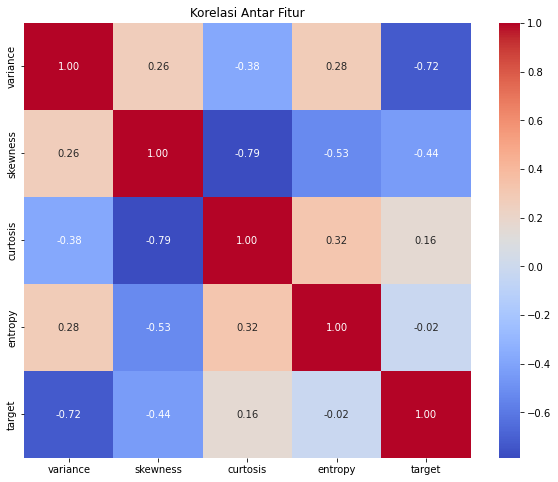

In [478]:
# I.3 Put your code here
# 1. Korelasi antar fitur
correlation_matrix = df.corr()

# Plot matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur')
plt.show()

In [479]:
# 2. Distribusi setiap fitur kategorikal
def categorical_distribution(df):
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        plt.figure(figsize=(8, 6))
        sns.countplot(x=feature, data=df)
        plt.title(f'Distribusi {feature}')
        plt.show()

def numerical_distribution(df):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    for feature in numeric_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=feature, kde=True)
        plt.title(f'Distribution of {feature}')
        plt.show()

In [480]:
categorical_distribution(df)

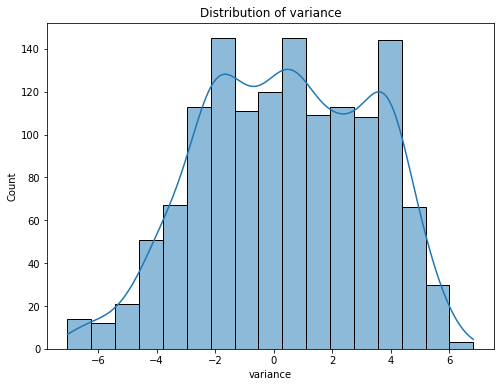

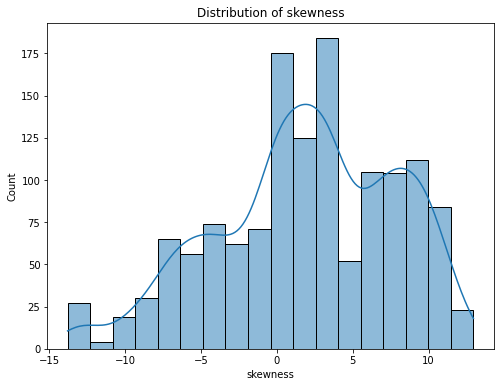

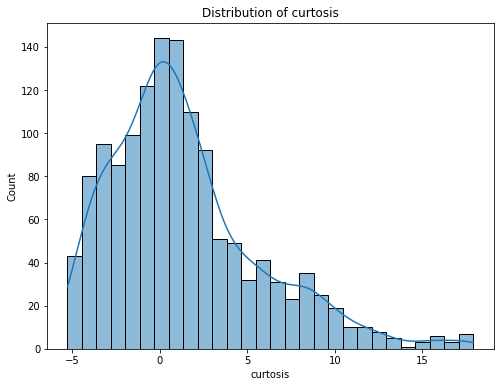

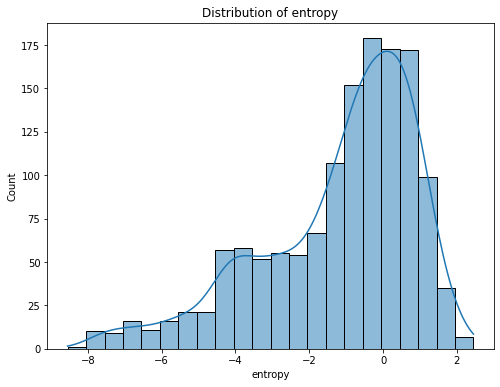

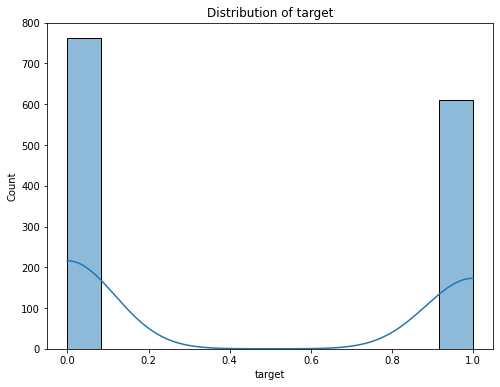

In [481]:
numerical_distribution(df)

In [482]:
# 3. Visualisasikan distribusi dari tiap fitur, dengan data dibagi tiap unique values fitur survived 
def numerical_distribution_survived(df):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    for feature in numeric_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=feature, hue='target', kde=True)
        plt.title(f'Distribusi {feature} - Dibagi berdasarkan Survived')
        plt.show()

def categorical_distribution_survived(df):
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=feature, hue='target')
        plt.title(f'Distribusi {feature} - Dibagi berdasarkan Survived')
        plt.show()

In [483]:
categorical_distribution_survived(df)

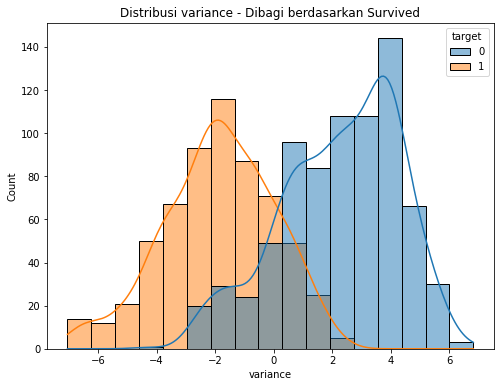

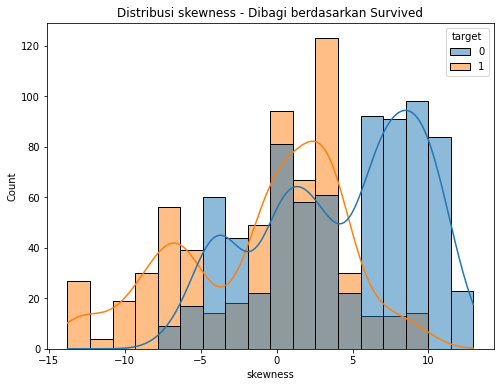

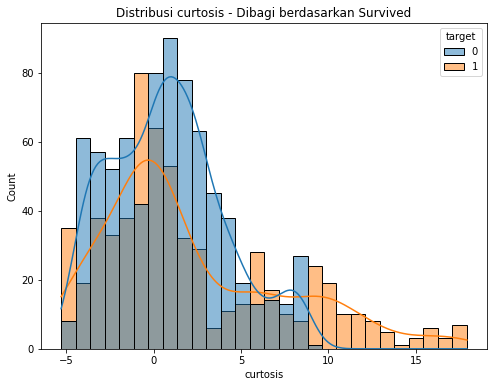

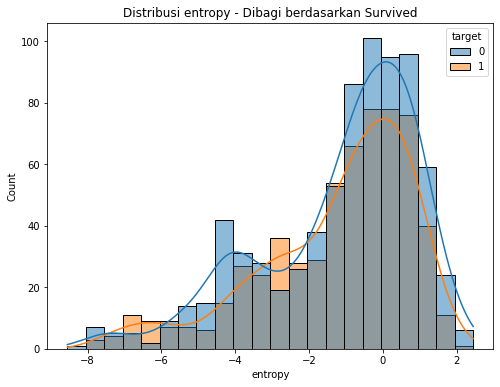

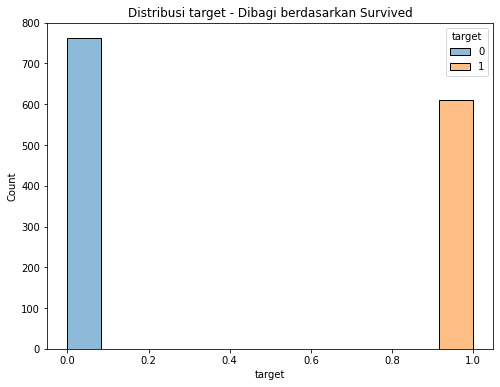

In [484]:
numerical_distribution_survived(df)

## I.4
Lakukanlah analisa pada data lebih lanjut jika dibutuhkan, kemudian lakukanlah:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan missing values
4. Transformasi data kategorikal menjadi numerikal (encoding), dengan metode yang kalian inginkan
5. Lakukan scaling dengan MinMaxScaler

Tidak ada missing values sehingga tidak perlu dilakukan penanganan

Tidak ada fitur kategorikal sehingga tidak perlu dilakukan encoding

Korelasi antar fitur terlihat sangat tinggi sehingga performa model machine learning bisa saja turun jika ada fitur didrop

### Handling Duplicate Rows

In [485]:
# Get the number of rows before removing duplicates
num_rows_before = len(df)

# Remove duplicate rows from df
df = df.drop_duplicates()

# Get the number of rows after removing duplicates
num_rows_after = len(df)

# Print the number of rows before and after removing duplicates
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")

Number of rows before removing duplicates: 1372
Number of rows after removing duplicates: 1348


### Handling Outliers

In [486]:
df = find_outliers(df)

Outliers dari tiap fitur (metode IQR - Interquartile Range):
variance:
Tidak ada

skewness:
Tidak ada

curtosis:
      variance  skewness  curtosis   entropy  target
765    -3.8483  -12.8047   15.6824 -1.281000       1
780    -3.5801  -12.9309   13.1779 -2.567700       1
815    -3.1128   -6.8410   10.7402 -1.017200       1
816    -4.8554   -5.9037   10.9818 -0.821990       1
820    -4.0025  -13.4979   17.6772 -3.320200       1
821    -4.0173   -8.3123   12.4547 -1.437500       1
826    -4.2110  -12.4736   14.9704 -1.388400       1
841    -3.8858  -12.8461   12.7957 -3.135300       1
877    -5.1216   -5.3118   10.3846 -1.061200       1
881    -4.4861  -13.2889   17.3087 -3.219400       1
882    -4.3876   -7.7267   11.9655 -1.454300       1
887    -3.2692  -12.7406   15.5573 -0.141820       1
902    -2.8957  -12.0205   11.9149 -2.755200       1
937    -2.9020   -7.6563   11.8318 -0.842680       1
938    -4.3773   -5.5167   10.9390 -0.408200       1
942    -3.3793  -13.7731   17.9274 -2.0

### Feature Scaling

In [487]:
# Feature Scaling
# Split X and Y
X = df.drop('target', axis=1)
y = df['target']

# Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# II. Experiments Design
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal ini meliputi:
1. Pembuatan model
2. Proses validasi
3. Hyperparameter tuning

## II.1
Tentukanlah metrics yang akan digunakan pada eksperimen kali ini (dapat lebih dari 1 metric)

1. Akurasi (Accuracy): Akurasi mengukur seberapa banyak prediksi yang benar dibagi dengan jumlah total data.

2. Presisi (Precision): Presisi mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan total prediksi positif yang dilakukan oleh model.

3. Recall (Sensitivitas atau True Positive Rate): Recall mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan total data sebenarnya yang bernilai positif.

4. F1-Score: F1-score adalah harmonic mean dari presisi dan recall.

## II.2 
Bagi data dengan perbandingan 0.8 untuk data train dan 0.2 untuk data validasi

### Split Training and Test Set

In [488]:
# Bagi data menjadi train set dan test set (misalnya 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## II.3
Lakukanlah:
1. Prediksi dengan menggunakan model Logistic Regression sebagai *baseline*
2. Tampilkan evaluasi dari model yang dibangun dari metrics yang anda tentukan pada II.1
3. Tampilkan confusion matrix

### Logistic Regression

In [489]:
# 1. Define and train model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### Training Score

In [490]:
# 2. Make predictions using the trained model for training score
y_pred = model.predict(X_train)

In [491]:
# 3. Evaluate the model using the specified metrics
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Evaluation Metrics:
Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1 Score: 0.99


In [492]:
# Generate the classification report
class_report = classification_report(y_train, y_pred)

# Classification Report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       570
           1       0.98      1.00      0.99       435

    accuracy                           0.99      1005
   macro avg       0.99      0.99      0.99      1005
weighted avg       0.99      0.99      0.99      1005



In [493]:
# 4. Display the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[561   9]
 [  1 434]]


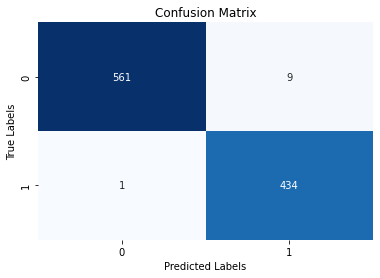

In [494]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### Test Score

In [495]:
# 2. Make predictions using the trained model for test score
y_pred = model.predict(X_test)

In [496]:
# 3. Evaluate the model using the specified metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Evaluation Metrics:
Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1 Score: 0.99


In [497]:
# Generate the classification report
class_report_baseline = classification_report(y_test, y_pred)

# Classification Report
print("Classification Report:")
print(class_report_baseline)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [498]:
# 4. Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[151   2]
 [  0  99]]


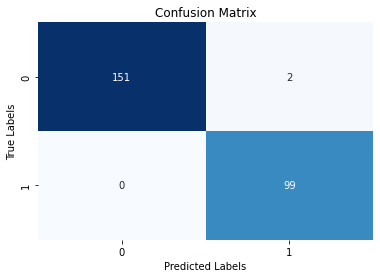

In [499]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. Hyperparameter tuning model yang kalian pakai dengan menggunakan Grid Search (perhatikan random factor pada beberapa algoritma model)
3. Lakukan validasi dengan menggunakan cross validation


### Random Forest Classifier

In [500]:
# Define and train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [501]:
# Define hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [502]:
# Hyperparameter Tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [503]:
# Get the best model
best_rf_model = grid_search.best_estimator_

In [504]:
# Validation with Cross Validation
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the results
print("Cross Validation Scores:")
print(cv_scores)

Cross Validation Scores:
[0.99502488 0.99502488 1.         0.99502488 0.9800995 ]


In [505]:
print("Best Model Hyperparameters:")
print(grid_search.best_params_)

Best Model Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


#### Training Score

In [506]:
# Evaluation metrics for the best model
y_pred = best_rf_model.predict(X_train)
class_report_rf = classification_report(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)

In [507]:
print("Classification Report:")
print(class_report_rf)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       570
           1       1.00      1.00      1.00       435

    accuracy                           1.00      1005
   macro avg       1.00      1.00      1.00      1005
weighted avg       1.00      1.00      1.00      1005



In [508]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[570   0]
 [  0 435]]


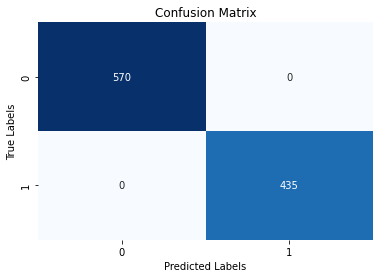

In [509]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### Test Score

In [510]:
# Evaluation metrics for the best model
y_pred = best_rf_model.predict(X_test)
class_report_rf = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [511]:
print("Classification Report:")
print(class_report_rf)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



In [512]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[153   0]
 [  0  99]]


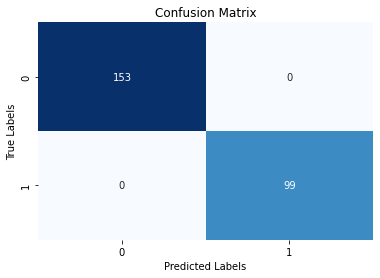

In [513]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# III. Improvement
Terdapat beberapa metode untuk melakukan peningkatan performa, contohnya adalah:
1. Melakukan oversampling / undersampling pada data
2. Menggabungkan beberapa model 

Pada bagian ini, kalian diharapkan dapat:
1. Melakukan training dengan data hasil oversampling / undersampling dan melakukan validasi dengan benar
2. Memahami beberapa metode untuk menggabungkan beberapa model

## III.1
Lakukanlah:
1. Oversampling pada kelas minoritas pada data train, kemudian train dengan model *baseline* (II.3), lakukan validasi dengan data validasi. Data train dan validasi adalah data yang kalian bagi pada bagian II.2
2. Undersampling pada kelas mayoritas pada data train, kemudian train dengan model *baseline* (II.3) lakukan validasi dengan data validasi. Data train dan validasi adalah data yang kalian bagi pada bagian II.2

In [514]:
# III.1 Put your code here
# Oversampling on the minority class
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [515]:
# Train with Logistic Regression (baseline model)
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=42)

In [516]:
# Validation
y_pred_lr = lr_model.predict(X_test)
class_report_oversampled = classification_report(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

In [517]:
print(class_report_oversampled)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.97      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [518]:
print(conf_matrix_lr)

[[150   3]
 [  0  99]]


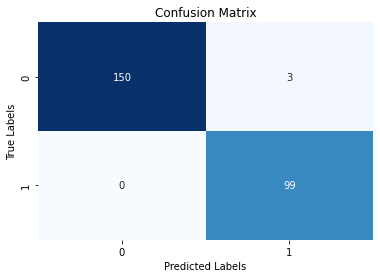

In [519]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [520]:
# Undersampling on the majority class
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [521]:
# Train with Logistic Regression (baseline model)
lr_model_undersampled = LogisticRegression(random_state=42)
lr_model_undersampled.fit(X_train_undersampled, y_train_undersampled)

LogisticRegression(random_state=42)

In [522]:
# Validation
y_pred_lr_undersampled = lr_model_undersampled.predict(X_test)
class_report_lr_undersampled = classification_report(y_test, y_pred_lr_undersampled)
conf_matrix_lr_undersampled = confusion_matrix(y_test, y_pred_lr_undersampled)

In [523]:
print(class_report_lr_undersampled)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.97      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [524]:
print(conf_matrix_lr_undersampled)

[[150   3]
 [  0  99]]


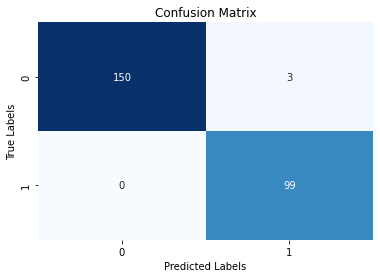

In [525]:
# Featmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_undersampled, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## III.2
Lakukanlah:
1. Eksplorasi soft voting, hard voting, dan stacking
2. Buatlah model Logistic Regression dan SVM (boleh menggunakan model dengan beberapa parameter yang berbeda)
3. Lakukanlah soft voting dari model-model yang sudah kalian buat pada poin 2
4. Lakukan hard voting dari model-model yang sudah kalian buat pada poin 2
5. Lakukanlah stacking dengan final classifier adalah Logistic Regression dari model-model yang sudah kalian buat pada poin 2
6. Lakukan validasi dengan metrics yang kalian tentukan untuk poin 3, 4, dan 5

Put your answer for section III.2 point 1 here

In [526]:
# Define models
lr_model1 = LogisticRegression(C=1.0, random_state=42)
lr_model2 = LogisticRegression(C=0.1, random_state=42)
svm_model1 = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model2 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)

In [527]:
# Soft Voting
soft_voting_clf = VotingClassifier(estimators=[('lr1', lr_model1), ('lr2', lr_model2), ('svm1', svm_model1), ('svm2', svm_model2)], voting='soft')
soft_voting_clf.fit(X_train, y_train)
y_pred_soft_voting = soft_voting_clf.predict(X_test)

In [528]:
# Evaluation Soft Voting
class_report_softvote = classification_report(y_test, y_pred_soft_voting)
print(class_report_softvote)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



In [529]:
# Hard voting
hard_voting_clf = VotingClassifier(estimators=[('lr1', lr_model1), ('lr2', lr_model2), ('svm1', svm_model1), ('svm2', svm_model2)], voting='hard')
hard_voting_clf.fit(X_train, y_train)
y_pred_hard_voting = hard_voting_clf.predict(X_test)

In [530]:
# Evaluation Hard Voting
class_report_hardvote = classification_report(y_test, y_pred_hard_voting)
print(class_report_hardvote)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [531]:
# Stacking with Logistic Regression as the final classifier
estimators = [('lr1', lr_model1), ('lr2', lr_model2), ('svm1', svm_model1), ('svm2', svm_model2)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

In [532]:
# Evaluation Stacking
class_report_stacking = classification_report(y_test, y_pred_stacking)
print(class_report_stacking)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



# IV. Analisis
Bandingkan hasil dari:
1. Model Baseline (II.3)
2. Model lain (II.4)
3. Hasil undersampling
4. Hasil oversampling
5. Hasil soft voting
6. Hasil hard voting
7. Hasil stacking 

In [533]:
# 1. Model Baseline
print(class_report_baseline)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [534]:
# 2. Model RFC
print(class_report_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



In [535]:
# 3. Model Undersampled
print(class_report_lr_undersampled)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.97      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [536]:
# 4. Model Oversampled
print(class_report_oversampled)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.97      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [537]:
# 5. Model Soft Voting
print(class_report_softvote)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



In [538]:
# 6. Model Hard Vote
print(class_report_hardvote)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99        99

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252



In [539]:
# 7. Model Stacking
print(class_report_stacking)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00        99

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



Untuk analisis, berdasarkan dari evaluasi metrik-metrik di atas, terlihat bahwa seluruh model menghasilkan performa yang sangat baik karena untuk semua test validasi, semua nilai metrik di atas 95% sehingga untuk dataset yang dipakai dalam eksperimen ini sangat bagus, membuat algoritma machine learning berhasil menghasilkan performa yang baik. Maka, terlihat bahwa perbedaan nilai metrik-metrik tidak jauh berbeda. Namun, secara teori, memang model yang lebih engineered seperti softvote, hardvote, dan stacking seharusnya menghasilkan performa yang lebih baik dibandingkan baseline model. Balancing class juga diperlukan agar model tidak overfit ke suatu class, dengan teknik oversampling atau undersampling. Kedua teknik ada kekurangan dan kelebihannya baik dari segi jumlah data dan keorisinalitas data.